In [1]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess

# clustering & embedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap

# other modules of mine
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

import sharepathway as sp

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

In [2]:
model_dir = '../data/GCN/training/2019_11_12_14_00_06/'
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))

args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(args['data'], 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]

pred = postprocessing.load_predictions(model_dir)

In [26]:
def get_cancer_genes():
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])

    oncokb_genes = pd.read_csv('../data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    return oncokb_genes, known_cancer_genes, candidate_cancer_genes


def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg)
    plt.fill_between(range(data.shape[0]), rolling_avg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)


def get_pathway_enrichment(genes, cluster_idx, out_dir):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                           os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                           genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_number)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)#, yerr=rep_std.values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=16)
    ax.set_ylabel('Feature Contribution')
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = x.max()
    vmin = x.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0}  {1:.2f}  {2}  {3}  {4}'.format(i, pathways.iloc[i]['Pvalue'],
                                                                   pathways.iloc[i]['Count'],
                                                                   pathways.iloc[i]['Size'],
                                                                   pathways.iloc[i]['Term']
                                                                  )
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

In [160]:
datatype = 'expression'

omics_to_num = {'mutation': 0, 'methylation': 1, 'expression': 2}
omic_level = feature_contributions[:, :, omics_to_num[datatype]]
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
omic_level = pd.DataFrame(omic_level, index=node_names[:, 1], columns=feature_names)

omic_level_nonzero = omic_level[~(omic_level == 0).all(axis=1)]
omic_level_nonzero.shape

(13618, 308)

{1.0: 'darkred', 2.0: 'darkgreen', 0.0: 'grey', 3.0: 'blue', 4.0: 'orange', 5.0: 'yellow'}
{'M0': 'darkred', nan: 'darkgreen', 'M1': 'grey'}
{'A2': (0.86, 0.3712, 0.33999999999999997), 'BH': (0.86, 0.5445333333333333, 0.33999999999999997), 'AN': (0.86, 0.7178666666666667, 0.33999999999999997), nan: (0.8287999999999999, 0.86, 0.33999999999999997), 'D8': (0.6554666666666664, 0.86, 0.33999999999999997), 'AO': (0.48213333333333297, 0.86, 0.33999999999999997), 'AQ': (0.33999999999999997, 0.86, 0.3712), 'E9': (0.33999999999999997, 0.86, 0.5445333333333332), 'EW': (0.33999999999999997, 0.86, 0.7178666666666667), 'B6': (0.33999999999999997, 0.8287999999999999, 0.86), 'A8': (0.33999999999999997, 0.6554666666666664, 0.86), 'E2': (0.33999999999999997, 0.48213333333333336, 0.86), 'C8': (0.3712, 0.33999999999999997, 0.86), 'AR': (0.5445333333333334, 0.33999999999999997, 0.86), 'GM': (0.7178666666666661, 0.33999999999999997, 0.86), 'A7': (0.86, 0.33999999999999997, 0.8287999999999999), 'AC': (0.86, 

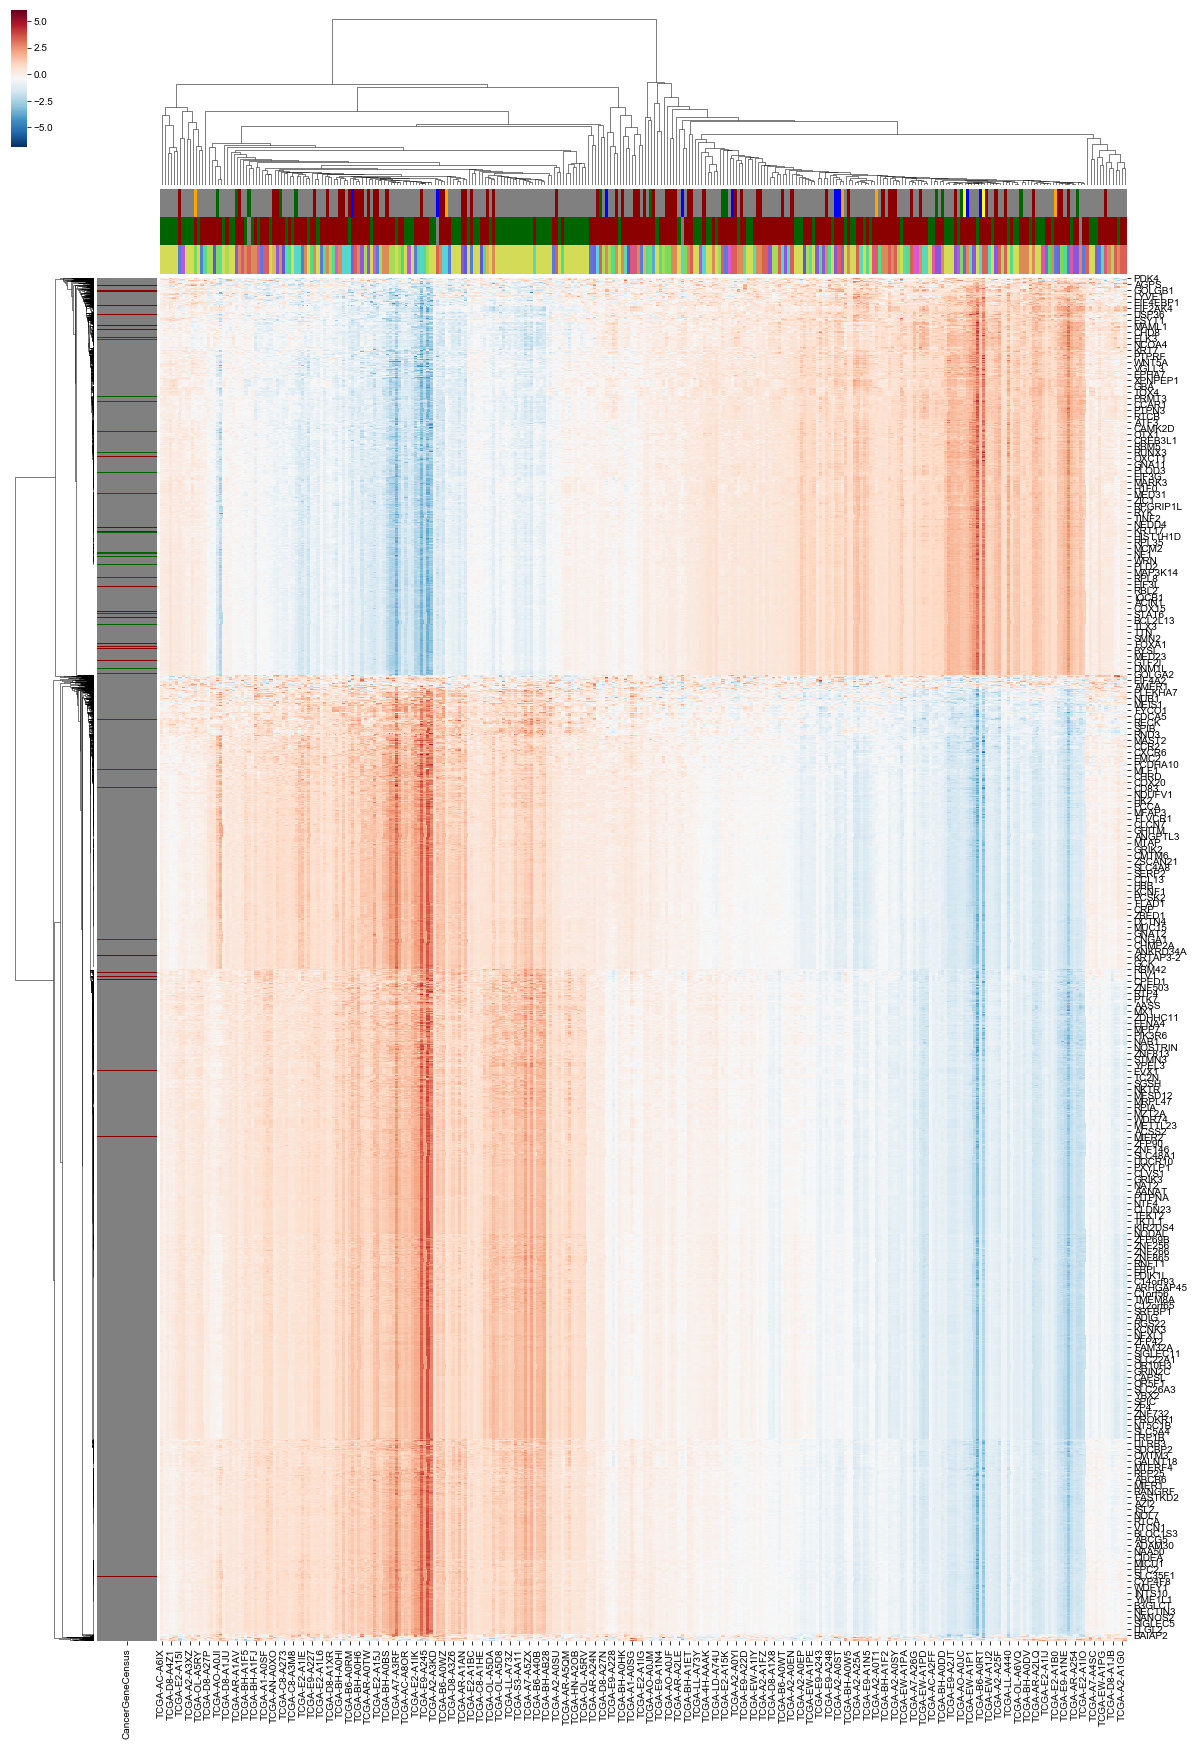

In [161]:
sys.setrecursionlimit(10000)

# literature genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(omic_level_nonzero.shape[0])
onco_tsg_annotation[omic_level_nonzero.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[omic_level_nonzero.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=omic_level_nonzero.index, name='CancerGeneCensus')
lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# cancer subtypes
clinical = pd.read_csv('../data/cancer_specific/BRCA_subtypes/BRCA_original_clinical.csv', sep='\t', header=1)
clinical.set_index('Complete TCGA ID', inplace=True)
subtype = np.zeros(omic_level_nonzero.shape[1])
subtype[omic_level_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Luminal A'].index)] = 1
subtype[omic_level_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Luminal B'].index)] = 2
subtype[omic_level_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Basal-like'].index)] = 3
subtype[omic_level_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'HER2-enriched'].index)] = 4
subtype[omic_level_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Normal-like'].index)] = 5
subtype = pd.Series(subtype, index=omic_level_nonzero.columns, name='Subtype')
lut_col = dict(zip(subtype.unique(), ['darkred', 'darkgreen', 'grey', 'blue', 'orange', 'yellow']))
col_colors = subtype.map(lut_col)

metastasis = clinical.Metastasis.reindex(omic_level_nonzero.columns)
lut_col2 = dict(zip(metastasis.unique(), ['darkred', 'darkgreen', 'grey', 'blue', 'orange', 'yellow']))
col_colors2 = metastasis.map(lut_col2)

clinical['TSS'] = [i[1] for i in clinical.index.str.split('-')]
tss = clinical.TSS.reindex(omic_level_nonzero.columns)
lut_col3 = dict(zip(tss.unique(), sns.color_palette("hls", tss.nunique()+1)))
col_colors3 = tss.map(lut_col3)
print (lut_col)
print (lut_col2)
print (lut_col3)
# perform the clustering
clu = sns.clustermap(omic_level_nonzero,
                     #row_linkage=Z,
                     z_score=0, # axis 0
                     metric='correlation',
                     figsize=(20, 30),
                     col_cluster=True,
                     yticklabels=60,
                     xticklabels=3,
                     row_colors=row_colors,
                     col_colors=[col_colors, col_colors2, col_colors3],
                     cmap="RdBu_r"
                    )
clu.savefig(os.path.join(model_dir, 'clustering_lrp_{}.png'.format(datatype)), dpi=300)

In [162]:
flat_clusters = hierarchy.cut_tree(clu.dendrogram_col.linkage, n_clusters=2)

cluster_0_patients = omic_level_nonzero.columns[flat_clusters.reshape(-1) == 0]

cluster_1_patients = omic_level_nonzero.columns[flat_clusters.reshape(-1) == 1]

pd.Series(cluster_0_patients).to_csv(os.path.join(model_dir, 'cluster_0_patients.csv'), header=False, index=False)
pd.Series(cluster_1_patients).to_csv(os.path.join(model_dir, 'cluster_1_patients.csv'), header=False, index=False)

In [164]:
omic_level_nonzero[cluster_0_patients].max(axis=1).sort_values(ascending=False).head(10)

PCDHGB4    62.629
FAM98B     17.444
USP16      17.058
OTX2       16.795
PLK4        8.267
ROBO4       8.255
TMEM185A    7.814
ADAM17      7.763
INS         7.523
FGF14       6.681
dtype: float64

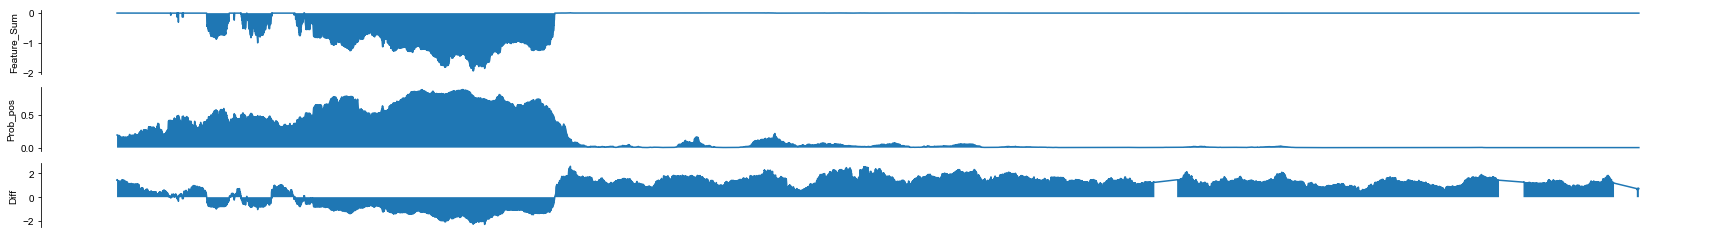

In [27]:
feature_contribution_sum = pd.Series(omic_level_nonzero.sum(axis=1), name='Feature_Sum')
feat_contrib_predictions = pred.join(feature_contribution_sum, on='Name')
feat_contrib_predictions['Diff'] = feat_contrib_predictions.Feature_Sum / (feat_contrib_predictions.Prob_pos + 0.0001)
feat_contrib_predictions['Idx_Num'] = range(feat_contrib_predictions.shape[0])

feature_contribs_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Feature_Sum']
predictions_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Prob_pos']
diff_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Diff']




fig = plt.figure(figsize=(30, 4))
ax = plt.subplot(3, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex)
ax = plt.subplot(3, 1, 2)
plot_rolling_avg(ax, predictions_dendroindex)
ax = plt.subplot(3, 1, 3)
plot_rolling_avg(ax, diff_dendroindex)
fig.savefig(os.path.join(model_dir, 'feature_contribution_density_{}.png'.format(datatype)), dpi=300)

In [7]:
len(list(feature_names)*3)

924

In [13]:
all_omics = feature_contributions.reshape(feature_contributions.shape[0], -1, order='F')
all_omics = pd.DataFrame(all_omics, index=node_names[:, 1], columns=list(feature_names)*3)

all_omics_nonzero = all_omics[~(all_omics == 0).all(axis=1)]
all_omics_nonzero.shape

(13618, 924)

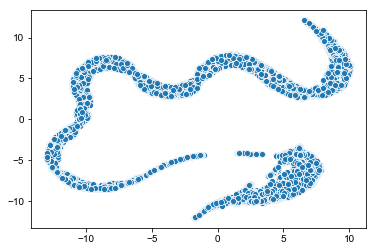

In [9]:
import umap
embedding = umap.UMAP(n_components=2).fit_transform(all_omics_nonzero)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])

{1.0: 'darkred', 2.0: 'darkgreen', 0.0: 'grey', 3.0: 'blue', 4.0: 'orange', 5.0: 'yellow'}


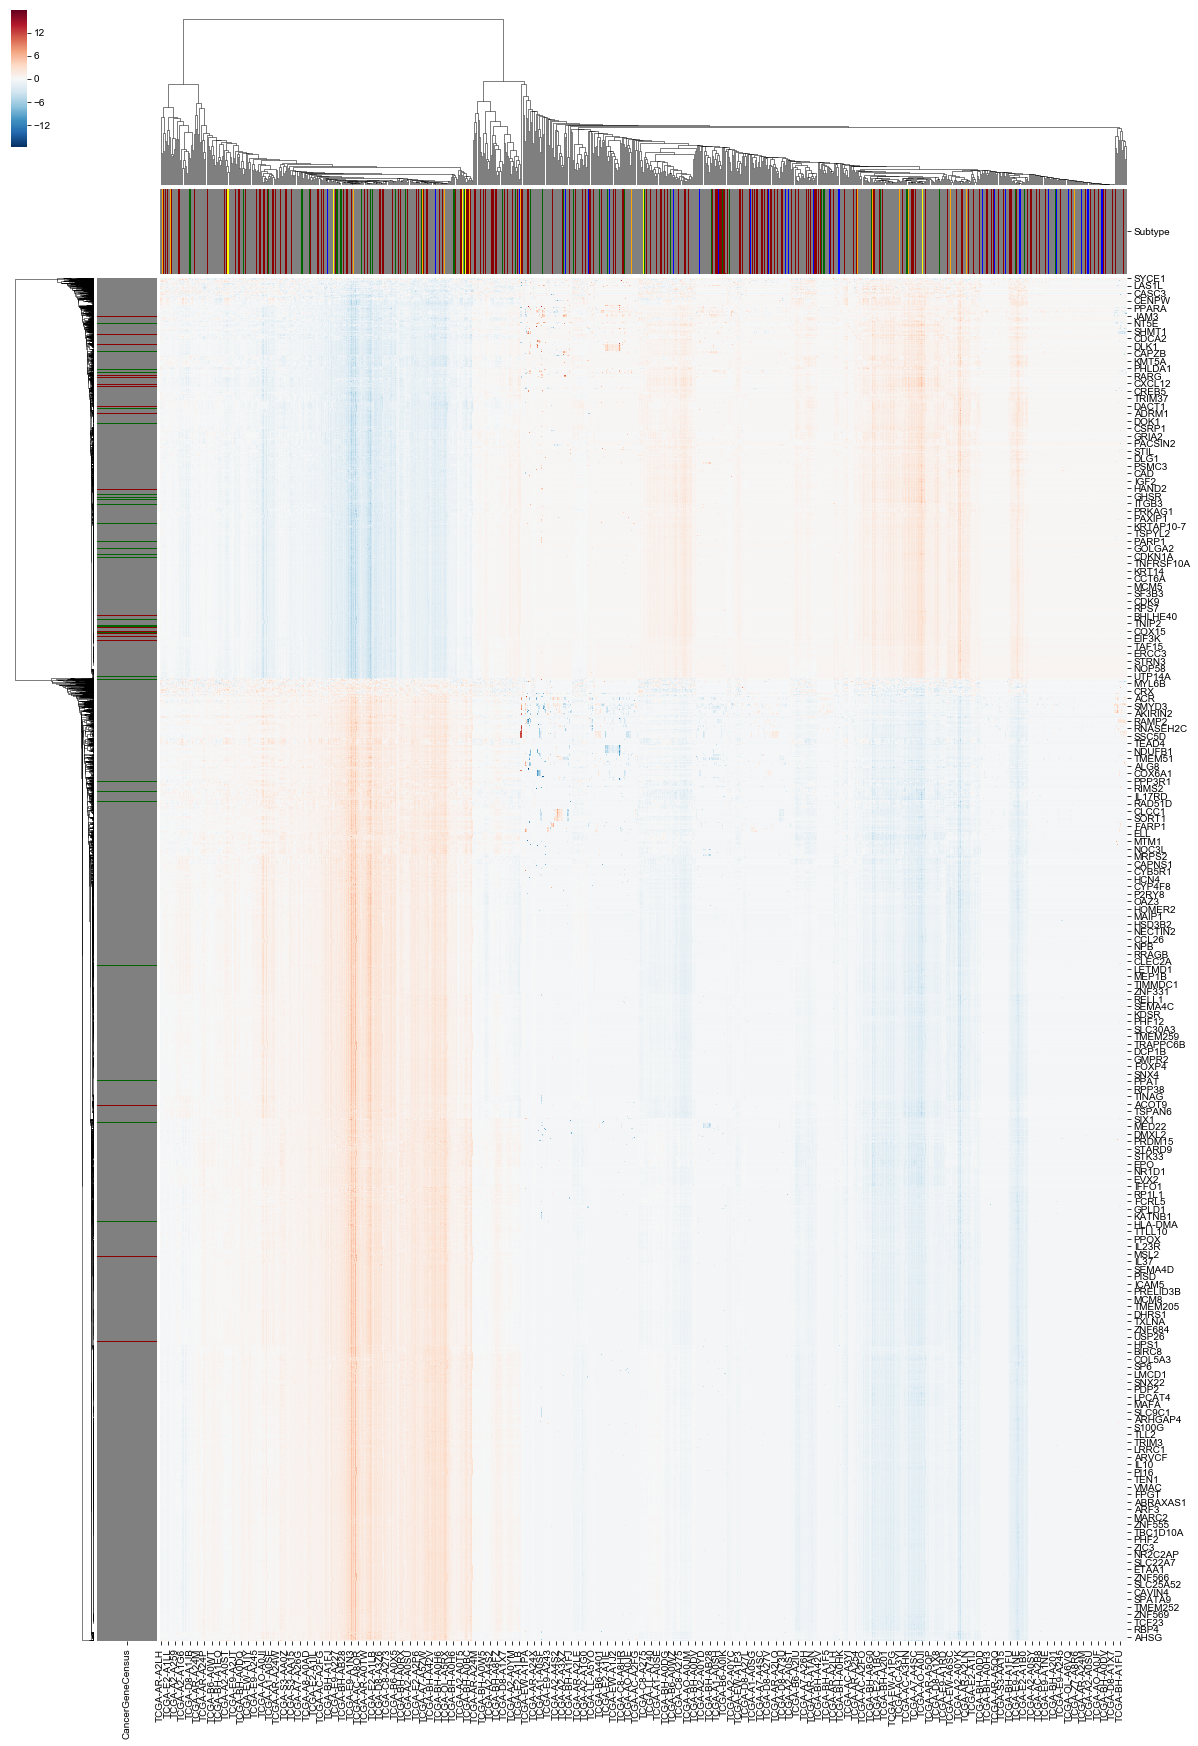

In [22]:
sys.setrecursionlimit(10000)

# literature genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(all_omics_nonzero.shape[0])
onco_tsg_annotation[all_omics_nonzero.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[all_omics_nonzero.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=all_omics_nonzero.index, name='CancerGeneCensus')
lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# cancer subtypes
clinical = pd.read_csv('../data/cancer_specific/BRCA_subtypes/BRCA_original_clinical.csv', sep='\t', header=1)
clinical.set_index('Complete TCGA ID', inplace=True)
subtype = np.zeros(all_omics_nonzero.shape[1])
subtype[all_omics_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Luminal A'].index)] = 1
subtype[all_omics_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Luminal B'].index)] = 2
subtype[all_omics_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Basal-like'].index)] = 3
subtype[all_omics_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'HER2-enriched'].index)] = 4
subtype[all_omics_nonzero.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Normal-like'].index)] = 5
subtype = pd.Series(subtype, index=all_omics_nonzero.columns, name='Subtype')
lut_col = dict(zip(subtype.unique(), ['darkred', 'darkgreen', 'grey', 'blue', 'orange', 'yellow']))
col_colors = subtype.map(lut_col)
print (lut_col)
# perform the clustering
clu = sns.clustermap(all_omics_nonzero,
                     #row_linkage=Z,
                     z_score=0, # axis 0
                     metric='cosine',
                     figsize=(20, 30),
                     col_cluster=True,
                     yticklabels=75,
                     xticklabels=7,
                     row_colors=row_colors,
                     col_colors=col_colors,
                     cmap="RdBu_r"
                    )
#clu.savefig(os.path.join(model_dir, 'clustering_lrp_{}.png'.format(datatype)), dpi=300)

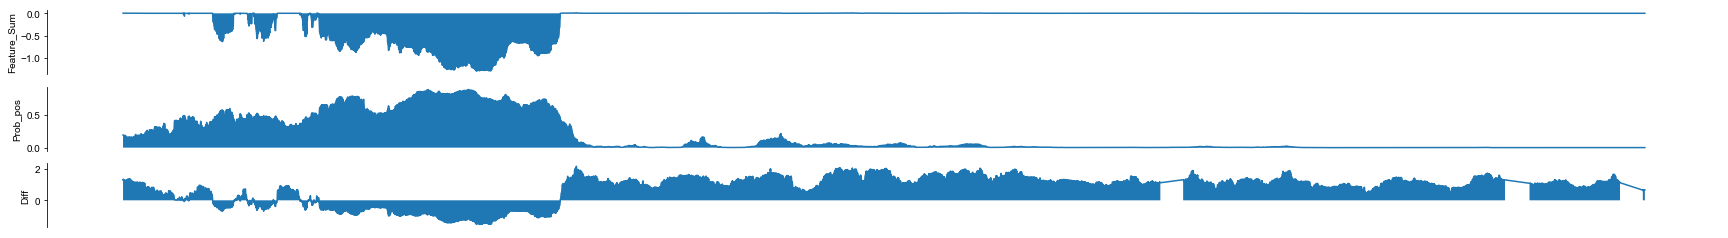

In [28]:
feature_contribution_sum = pd.Series(all_omics_nonzero.sum(axis=1), name='Feature_Sum')
feat_contrib_predictions = pred.join(feature_contribution_sum, on='Name')
feat_contrib_predictions['Diff'] = feat_contrib_predictions.Feature_Sum / (feat_contrib_predictions.Prob_pos + 0.0001)
feat_contrib_predictions['Idx_Num'] = range(feat_contrib_predictions.shape[0])

feature_contribs_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Feature_Sum']
predictions_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Prob_pos']
diff_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Diff']




fig = plt.figure(figsize=(30, 4))
ax = plt.subplot(3, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex)
ax = plt.subplot(3, 1, 2)
plot_rolling_avg(ax, predictions_dendroindex)
ax = plt.subplot(3, 1, 3)
plot_rolling_avg(ax, diff_dendroindex)
#fig.savefig(os.path.join(model_dir, 'feature_contribution_density_{}.png'.format(datatype)), dpi=300)

In [83]:
flat_clusters = hierarchy.cut_tree(clu.dendrogram_col.linkage, n_clusters=2)

cols_cluster0 = all_omics_nonzero.columns[flat_clusters.reshape(-1) == 0]
cluster_0_patients = cols_cluster0.unique()[cols_cluster0.value_counts() >= 2]

cols_cluster1 = all_omics_nonzero.columns[flat_clusters.reshape(-1) == 1]
cluster_1_patients = cols_cluster1.unique()[cols_cluster1.value_counts() >= 2]

pd.Series(cluster_0_patients).to_csv(os.path.join(model_dir, 'cluster_0_patients.csv'), header=False, index=False)
pd.Series(cluster_1_patients).to_csv(os.path.join(model_dir, 'cluster_1_patients.csv'), header=False, index=False)

In [90]:
cluster_1_patients.isin(cluster_0_patients)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

{1.0: 'darkred', 2.0: 'darkgreen', 0.0: 'grey', 3.0: 'blue', 4.0: 'orange', 5.0: 'yellow'}


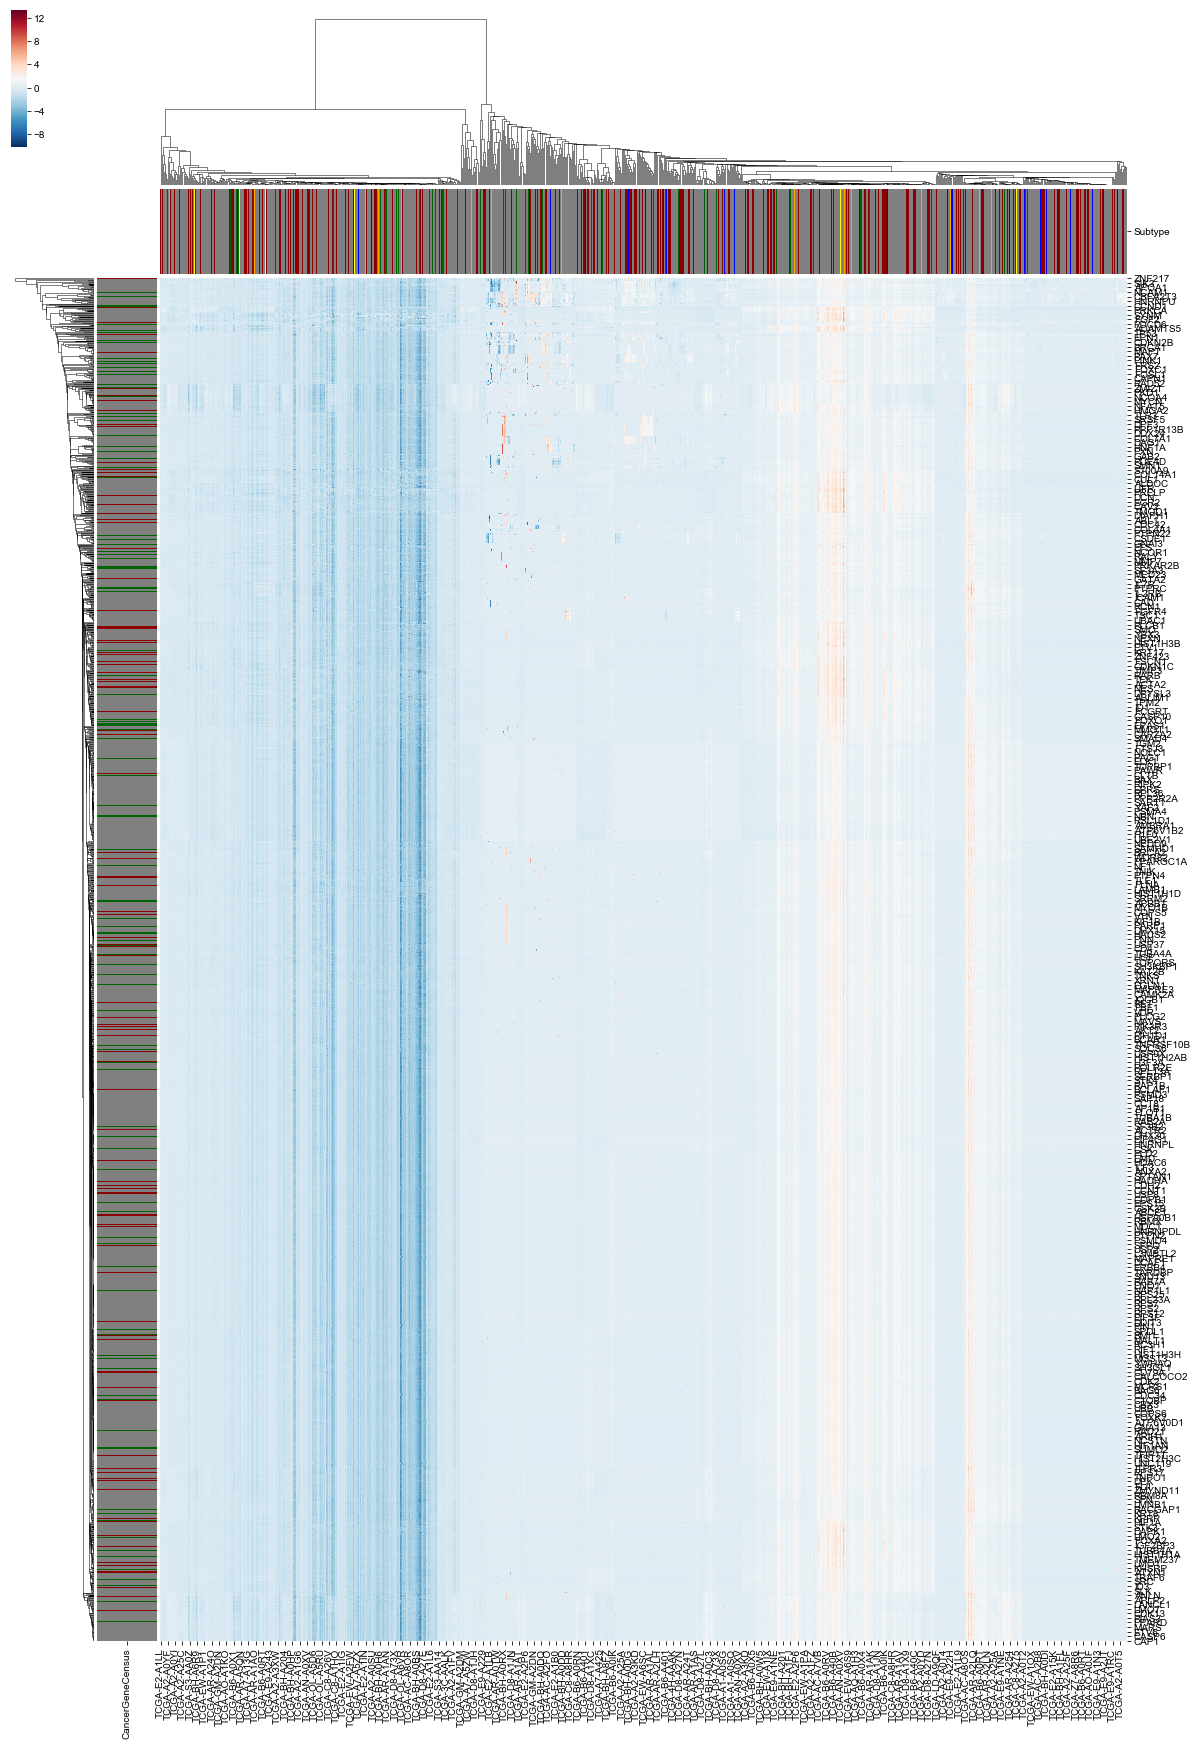

In [34]:
top1000 = all_omics_nonzero[all_omics_nonzero.index.isin(pred[pred.Prob_pos > 0.85].Name)]

# literature genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(top1000.shape[0])
onco_tsg_annotation[top1000.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[top1000.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=top1000.index, name='CancerGeneCensus')
lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# cancer subtypes
clinical = pd.read_csv('../data/cancer_specific/BRCA_subtypes/BRCA_original_clinical.csv', sep='\t', header=1)
clinical.set_index('Complete TCGA ID', inplace=True)
subtype = np.zeros(top1000.shape[1])
subtype[top1000.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Luminal A'].index)] = 1
subtype[top1000.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Luminal B'].index)] = 2
subtype[top1000.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Basal-like'].index)] = 3
subtype[top1000.columns.isin(clinical[clinical['PAM50 mRNA'] == 'HER2-enriched'].index)] = 4
subtype[top1000.columns.isin(clinical[clinical['PAM50 mRNA'] == 'Normal-like'].index)] = 5
subtype = pd.Series(subtype, index=top1000.columns, name='Subtype')
lut_col = dict(zip(subtype.unique(), ['darkred', 'darkgreen', 'grey', 'blue', 'orange', 'yellow']))
col_colors = subtype.map(lut_col)
print (lut_col)
# perform the clustering
clu = sns.clustermap(top1000,
                     #row_linkage=Z,
                     z_score=0, # axis 0
                     metric='cosine',
                     figsize=(20, 30),
                     col_cluster=True,
                     yticklabels=7,
                     xticklabels=7,
                     row_colors=row_colors,
                     col_colors=col_colors,
                     cmap="RdBu_r"
                    )
#clu.savefig(os.path.join(model_dir, 'clustering_lrp_{}.png'.format(datatype)), dpi=300)